# BioGPT-PubMedQA-Prefix-Tuning
### The objective is to fine-tune BioGPT for enhanced performance in addressing medical inquiries

## Install libraries used

In [4]:
!pip install peft transformers datasets sacremoses seaborn accelerate

In [5]:
!pip install torch torchvision torchaudio


## Import libraries used

In [6]:
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.optim import AdamW
from torch.nn import CrossEntropyLoss
from enum import Enum
from datasets import load_dataset, DatasetDict, Dataset
from transformers import (
    BioGptTokenizer,
    set_seed,
    get_scheduler,
    get_linear_schedule_with_warmup,
    BioGptForCausalLM,
    default_data_collator,
    TrainingArguments
)
from peft import (
    get_peft_config,
    get_peft_model,
    PrefixTuningConfig,
    TaskType,
    PeftType,
    AutoPeftModelForCausalLM,
    LoraConfig
    # removed: prepare_model_for_int8_training (optional)
)
from tqdm import tqdm
from accelerate import Accelerator
import random
import os
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd


print("✅ Training complete.")


/Users/bhavanapoli/AI-HealthBoard/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


✅ Training complete.


# PubMedQA Dataset
PubMedQA (Closed-domain question answering given PubMed abstract) dataset contains questions on biomedical research that cover a wide range of biomedical topics, including diseases, treatments, genes, proteins, and more. PubMedQA is one of the MultiMedQA datasets (A benchmark for medical question answering). PubMedQA consists of 1k expert labeled, 61.2k unlabeled, and 211.3k artificially generated QA instances with yes/no/maybe multiple-choice answers and long answers given a question together with a PubMed abstract as context
<div  style="text-align:center;"><img src="attachment:d6c728fe-797a-43f5-bd3f-303e3b1f79c7.png" width="300px" heigth="300px"></div>

## Load Dataset

In [7]:
from datasets import load_dataset

dataset = load_dataset("reginaboateng/cleaned_pubmedqa")


In [8]:
from datasets import load_dataset

dataset = load_dataset("pubmed_qa", "pqa_artificial")


## Data Preparation for QA Model

In [9]:
!pip install datasets


In [10]:
from datasets import load_dataset, Dataset, DatasetDict
import random

# Step 1: Load the PubMedQA dataset (pqa_labeled is the expert-annotated subset)
pubmed_qa = load_dataset("pubmed_qa", "pqa_labeled")

# Step 2: Extract question-answer pairs
data = []
for row in pubmed_qa['train']:
    question = row['question']
    answer = row['long_answer']
    data.append({'Question': question, 'Answer': answer})

# Step 3: Shuffle and create training set
train = data[:50]
random.shuffle(train)
train_mapping = {key: [d[key] for d in train] for key in train[0]}
train_dataset = Dataset.from_dict(train_mapping)

# Step 4: Shuffle and create validation set
validation = data[50:60]
random.shuffle(validation)
val_mapping = {key: [d[key] for d in validation] for key in validation[0]}
val_dataset = Dataset.from_dict(val_mapping)

# Step 5: Create final DatasetDict
dataset = DatasetDict({'train': train_dataset, 'validation': val_dataset})

# Optional: See a sample
print(dataset['train'][0])


{'Question': 'Is it appropriate to implant kidneys from elderly donors in young recipients?', 'Answer': 'We conclude that patient and graft survival on transplanting kidneys from elderly donors to young recipients is superimposable on that obtained with young donors. However, renal function is better in the group of young donors.'}


## Training Data Sample

In [11]:
train_subset = dataset["train"].select(range(5))
for i in range(5):
    print('Question: ' ,train_subset["Question"][i])
    print('Answer: ',train_subset["Answer"][i])
    print()

Question:  Is it appropriate to implant kidneys from elderly donors in young recipients?
Answer:  We conclude that patient and graft survival on transplanting kidneys from elderly donors to young recipients is superimposable on that obtained with young donors. However, renal function is better in the group of young donors.

Question:  Is aneurysm repair justified for the patients aged 80 or older after aneurysmal subarachnoid hemorrhage?
Answer:  Better prognosis was obtained when ruptured aneurysm was repaired in the elderly than it was treated conservatively. From the results of this study, we should not hesitate to offer the definitive surgery for the elderly with aSAH.

Question:  Does HER2 immunoreactivity provide prognostic information in locally advanced urothelial carcinoma patients receiving adjuvant M-VEC chemotherapy?
Answer:  HER2 immunoreactivity might have a limited prognostic value for advanced urothelial carcinoma patients with adjuvant M-VEC.

Question:  30-Day and 1-y

## Distribution of Sentence Lengths

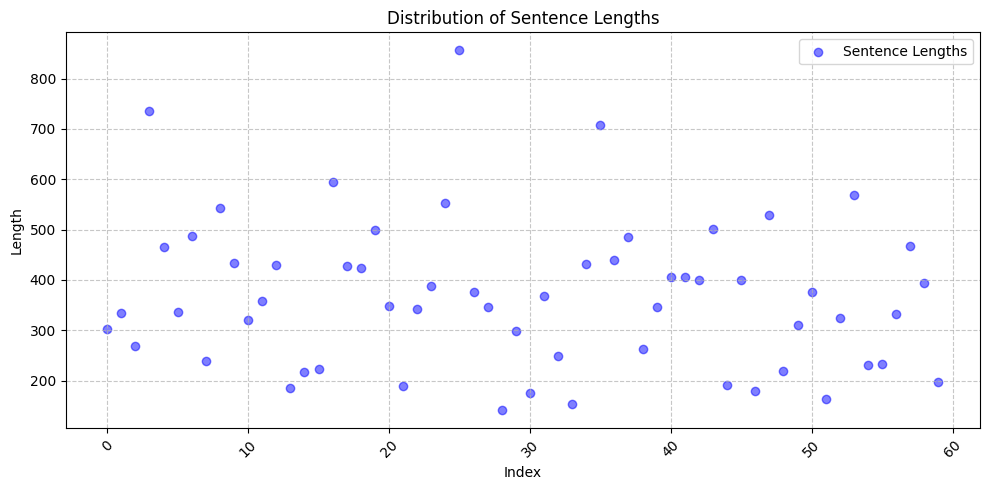

In [12]:
# Calculate lengths of tokenized sentences
lengths_list = []

# Process training data
for data in dataset['train']:
    length = len(data['Question'] + data['Answer'])
    lengths_list.append(length)

# Process validation data
for data in dataset['validation']:
    length = len(data['Question'] + data['Answer'])
    lengths_list.append(length)

# Create DataFrame
lengths = pd.DataFrame({'Length': lengths_list})

# Plotting
plt.figure(figsize=(10, 5))
plt.scatter(lengths.index, lengths['Length'], alpha=0.5, color='blue', label='Sentence Lengths')
plt.xlabel('Index')
plt.xticks(rotation=45)
plt.ylabel('Length')
plt.title('Distribution of Sentence Lengths')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()

# Prepare Model And Tokenizer

In [13]:
class SpecialTokens(str, Enum):
    question = "<|question|>"
    answer = "<|answer|>"
    medical = "<|medical|>"
    inquiry = "<|inquiry|>"
    pad_token = "<|pad|>"
    end_answer = "<|endanswer|>"
    @classmethod
    def list(cls):
        return [c.value for c in cls]

# BioGPT Tokenizer
- The GPT-2 tokenizer has a clever way to deal with characters that are not in the training corpus, these characters will be converted to the unknown token. That’s one reason why lots of NLP models are very bad at analyzing content with emojis.

- GPT-2 dones’t look at words as being written with Unicode characters, but with bytes. This way the base vocabulary has a small size (256), a huge vocabulary size means a huge embedding matrix at the start of the model, which will cause memory problems.
- Every character you can think of will still be included and not end up being converted to the unknown token. This trick is called byte-level BPE

<div style="text-align: center;">
    <img src="attachment:de3cb5a9-6a24-4305-8e7b-af42548e5558.png" width="500px" heigth="500px">
</div>

### Tokenization Steps:

 **1. Normalization**:
      
      * Removing spaces or accents, Unicode normalization, etc.

**2. Pre-tokenization**: 
        
        * Splitting the input into words: GPT-2 splits on whitespace and punctuation and keep spaces and replace them with a Ġ symbol(enabling it to recover the original spaces if we decode the tokens)
        
        * Compute the frequencies of each word
        
        * Create dictionary of words and the frequency

**3. Running the input through the Byte-Pair Encoding Model**:
        
        * Splitting each words in the dictionary into individual characters and compute the base vocabulary
        
        * Applying the merge rules learned in order on those splits
            * Split each word in vocabulary to characters and compute the frequency of each pair
            * Append pairs with large frequencies into the vocabulary
            * Apply all the merge rules learned to tokenize the text

**4. Post-processing**: 
       
       * Adding the special tokens of the tokenizer
       
       * Generate the attention mask and token type IDs)

## Load Tokenizer

In [14]:
tokenizer_name = "microsoft/BioGPT-Large-PubMedQA"  
tokenizer = BioGptTokenizer.from_pretrained(
    tokenizer_name,
    pad_token=SpecialTokens.pad_token.value,
    bos_token=SpecialTokens.question.value,
    eos_token=SpecialTokens.end_answer.value,
    additional_special_tokens=SpecialTokens.list(),
)

## BioGPT Tokenizer Info.

In [15]:
print("The max model length is {} for this model".format(tokenizer.model_max_length))
print('Is tokenizer fast: ' , tokenizer.is_fast)
print('The vocabulary size of the tokenizer is',  tokenizer.vocab_size)
print("The beginning of sequence token {} token has the id {}".format(tokenizer.convert_ids_to_tokens(tokenizer.bos_token_id), tokenizer.bos_token_id))
print("The end of sequence token {} has the id {}".format(tokenizer.convert_ids_to_tokens(tokenizer.eos_token_id), tokenizer.eos_token_id))
print("The padding token {} has the id {}".format(tokenizer.convert_ids_to_tokens(tokenizer.pad_token_id), tokenizer.pad_token_id))
special_tokens_map = tokenizer.special_tokens_map
print("Special Tokens Map:", special_tokens_map)

The max model length is 1024 for this model
Is tokenizer fast:  False
The vocabulary size of the tokenizer is 57726
The beginning of sequence token <|question|> token has the id 57726
The end of sequence token <|endanswer|> has the id 57727
The padding token <|pad|> has the id 57728
Special Tokens Map: {'bos_token': '<|question|>', 'eos_token': '<|endanswer|>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<|pad|>', 'additional_special_tokens': ['<|question|>', '<|answer|>', '<|medical|>', '<|inquiry|>', '<|pad|>', '<|endanswer|>']}


# BioGPT Model

### The Pre-trained Model is BioGPT
BioGPT, which was announced by Microsoft, used to analyze biomedical research with the aim of answering biomedical questions and can be especially relevant in helping researchers gain new insights. BioGPT is a type of generative Large Language Model (LLM), which is trained on millions of biomedical research articles that have already been published. This essentially means that BioGPT can use this information to perform other tasks like answering questions, extracting relevant data, and generating text relevant to biomedical.
The researchers used GPT-2 XL as the primary model and trained it on 15 million PubMed abstracts before using it in the real world. GPT-2 XL is a Transformer decoder that has 48 layers, 1600 hidden sizes, and 25 attention heads resulting in 1.5B parameters in total.

<div style="text-align: center;">
    <img src="attachment:e09bb0ac-2d0d-4bf7-8477-3df331d221a0.png" width="500px" heigth="500px">
</div>


## Load Pretrained Model

In [17]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM

# Use lighter model
model_name = "microsoft/BioGPT"  # ⬅️ Replace the large model

# Load tokenizer and model
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name)

# Set device (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Test output
prompt = "What are the effects of statins on cardiovascular health?"
inputs = tokenizer(prompt, return_tensors="pt").to(device)
output = model.generate(**inputs, max_length=200, do_sample=True)
response = tokenizer.decode(output[0], skip_special_tokens=True)

print("Response:", response)


Response: What are the effects of statins on cardiovascular health?


## Apply LoRA

In [18]:
config = LoraConfig(
    r=64, lora_alpha=128, lora_dropout=0.0, target_modules=["embed_tokens", "lm_head", "q_proj", "v_proj"]
)
model = get_peft_model(model, config)
print(model.print_trainable_parameters())
print(model)

trainable params: 9,069,568 || all params: 355,832,832 || trainable%: 2.5488
None
PeftModel(
  (base_model): LoraModel(
    (model): BioGptForCausalLM(
      (biogpt): BioGptModel(
        (embed_tokens): lora.Embedding(
          (base_layer): BioGptScaledWordEmbedding(42384, 1024, padding_idx=1)
          (lora_dropout): ModuleDict(
            (default): Identity()
          )
          (lora_A): ModuleDict()
          (lora_B): ModuleDict()
          (lora_embedding_A): ParameterDict(  (default): Parameter containing: [torch.FloatTensor of size 64x42384])
          (lora_embedding_B): ParameterDict(  (default): Parameter containing: [torch.FloatTensor of size 1024x64])
          (lora_magnitude_vector): ModuleDict()
        )
        (embed_positions): BioGptLearnedPositionalEmbedding(1026, 1024)
        (layers): ModuleList(
          (0-23): 24 x BioGptDecoderLayer(
            (self_attn): BioGptAttention(
              (k_proj): Linear(in_features=1024, out_features=1024, bias=

/Users/bhavanapoli/AI-HealthBoard/.venv/lib/python3.10/site-packages/peft/tuners/tuners_utils.py:574: UserWarning: Model with `tie_word_embeddings=True` and the tied_target_modules=['biogpt.embed_tokens'] are part of the adapter. This can lead to complications, for example when merging the adapter or converting your model to formats other than safetensors. See for example https://github.com/huggingface/peft/issues/2018.
  warnings.warn(


# Data Preprocessing

In [19]:
def preprocess_function(examples):
    max_length = 1024    
    batch_size = len(examples['Question'])
    
    inputs = ['Question: ' + str(x) for x in examples['Question']]
    targets = ['Answer: ' + str(x) for x in examples['Answer']]
    
    model_inputs = tokenizer(inputs)
    labels = tokenizer(targets)
    
    for i in range(batch_size):
        sample_input_ids = [tokenizer.bos_token_id] + model_inputs["input_ids"][i]
        label_input_ids = labels["input_ids"][i] + [tokenizer.eos_token_id]

        model_inputs["input_ids"][i] = sample_input_ids + label_input_ids
        labels["input_ids"][i] = [-100] * len(sample_input_ids) + label_input_ids
        model_inputs["attention_mask"][i] = [1] * len(model_inputs["input_ids"][i])

    for i in range(batch_size):
        sample_input_ids = model_inputs["input_ids"][i]
        label_input_ids = labels["input_ids"][i]
        
        model_inputs["input_ids"][i] = [tokenizer.pad_token_id] * (
            max_length - len(sample_input_ids)
        ) + sample_input_ids
        
        model_inputs["attention_mask"][i] = [0] * (max_length - len(sample_input_ids)) + model_inputs[
            "attention_mask"
        ][i]
        labels["input_ids"][i] = [-100] * (max_length - len(sample_input_ids)) + label_input_ids
        model_inputs["input_ids"][i] = torch.tensor(model_inputs["input_ids"][i][:max_length])
        model_inputs["attention_mask"][i] = torch.tensor(model_inputs["attention_mask"][i][:max_length])
        labels["input_ids"][i] = torch.tensor(labels["input_ids"][i][:max_length])
    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

In [20]:
processed_datasets = dataset.map(
    preprocess_function,
    batched=True,
    num_proc=1,
    remove_columns=dataset["train"].column_names,
    load_from_cache_file=False,
)
train_dataset = processed_datasets["train"]
eval_dataset = processed_datasets["validation"]
print(train_dataset)
print(eval_dataset)

Map: 100%|██████████| 10/10 [00:00<00:00, 610.10 examples/s]

Dataset({
    features: ['input_ids', 'attention_mask', 'labels'],
    num_rows: 50
})
Dataset({
    features: ['input_ids', 'attention_mask', 'labels'],
    num_rows: 10
})


## Tokenize one sentence

In [21]:
sentence = dataset['train'][3]['Question'] + dataset['train'][3]['Answer']
print(sentence, '\n')
print('The example length:', len(sentence),'\n')

print('tokens: ', tokenizer.tokenize(sentence),'\n')

tokenized_example = tokenizer(sentence)
print('Tokens type:', type(tokenized_example),'\n')
print('Tokens ids:\n', tokenized_example,'\n')
print('Tokens length:', len(tokenized_example['input_ids']),'\n')

decoded_example = tokenizer.decode(tokenized_example['input_ids'])
print('Converting to original text\n', decoded_example,'\n')

30-Day and 1-year mortality in emergency general surgery laparotomies: an area of concern and need for improvement?Emergency laparotomy carries a high rate of mortality, especially in those over the age of 70 years, and more needs to be done to improve outcomes, particularly in this group. This could involve increasing acute surgical care manpower, early recognition of patients requiring emergency surgery, development of clear management protocols for such patients or perhaps even considering centralisation of emergency surgical services to specialist centres with multidisciplinary teams involving emergency surgeons and care of the elderly physicians in hospital and related community outreach services for post-discharge care. 

The example length: 735 

tokens:  ['30</w>', '@-@</w>', 'Day</w>', 'and</w>', '1</w>', '@-@</w>', 'year</w>', 'mortality</w>', 'in</w>', 'emergency</w>', 'general</w>', 'surgery</w>', 'laparo', 'tomies</w>', ':</w>', 'an</w>', 'area</w>', 'of</w>', 'concern</w>

## Dataset Length After Tokenization 

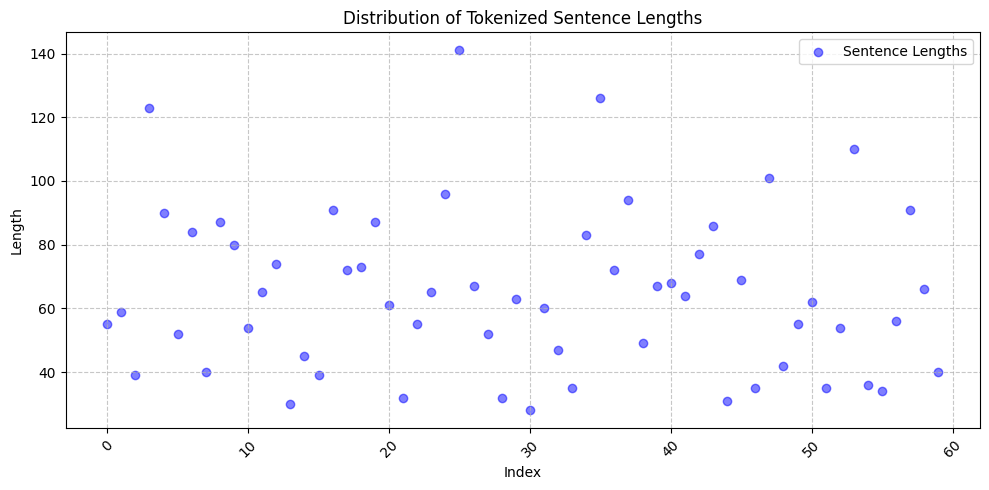

In [22]:
# Calculate lengths of tokenized sentences
lengths_list = []

# Process training data
for data in dataset['train']:
    length = len(tokenizer.encode(data['Question'] + data['Answer']))
    lengths_list.append(length)

# Process validation data
for data in dataset['validation']:
    length = len(tokenizer.encode(data['Question'] + data['Answer']))
    lengths_list.append(length)

# Create DataFrame
tokenized_lengths = pd.DataFrame({'Length': lengths_list})

# Plotting
plt.figure(figsize=(10, 5))
plt.scatter(tokenized_lengths.index, tokenized_lengths['Length'], alpha=0.5, color='blue', label='Sentence Lengths')
plt.xlabel('Index')
plt.xticks(rotation=45)
plt.ylabel('Length')
plt.title('Distribution of Tokenized Sentence Lengths')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()

## Data Loading

In [23]:
batch_size=8
train_dataloader = DataLoader(train_dataset, shuffle=True, collate_fn=default_data_collator, batch_size=batch_size, pin_memory=True)
eval_dataloader = DataLoader(eval_dataset, collate_fn=default_data_collator, batch_size=batch_size, pin_memory=True)

next(iter(train_dataloader))

/Users/bhavanapoli/AI-HealthBoard/.venv/lib/python3.10/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


{'input_ids': tensor([[   1,    1,    1,  ..., 1626,    4,    2],
         [   1,    1,    1,  ..., 3909,    4,    2],
         [   1,    1,    1,  ...,  114,    4,    2],
         ...,
         [   1,    1,    1,  ...,  113,    4,    2],
         [   1,    1,    1,  ..., 5653,    4,    2],
         [   1,    1,    1,  ...,  496,    4,    2]]),
 'attention_mask': tensor([[0, 0, 0,  ..., 1, 1, 1],
         [0, 0, 0,  ..., 1, 1, 1],
         [0, 0, 0,  ..., 1, 1, 1],
         ...,
         [0, 0, 0,  ..., 1, 1, 1],
         [0, 0, 0,  ..., 1, 1, 1],
         [0, 0, 0,  ..., 1, 1, 1]]),
 'labels': tensor([[-100, -100, -100,  ..., 1626,    4,    2],
         [-100, -100, -100,  ..., 3909,    4,    2],
         [-100, -100, -100,  ...,  114,    4,    2],
         ...,
         [-100, -100, -100,  ...,  113,    4,    2],
         [-100, -100, -100,  ..., 5653,    4,    2],
         [-100, -100, -100,  ...,  496,    4,    2]])}

# Train The Model

## Prefix Tuning - Soft Prompt

### Fine-tuning Process
To adapt BioGPT to answer medical inquiries, Prefix tuning used instead of full model finetuning on a small set of the PubMedQA which effectively used to instruct the model to produce text generations more aligned with the requirements of the medical domain.
#### Soft Prompt in Prefix Tuning
Large Language Models (LLMs) with hundreds of billions of parameters have become computationally expensive and very time-consuming to fine-tune. To address this issue, Lester et al. introduced prompt tuning, a computationally efficient method for adapting LLMs to specific downstream tasks, even with limited data, and a small number of labeled examples (e.g., tens)
Soft prompts in prefix tuning leverage continuous embeddings (virtual tokens) to steer the pre-trained language model by directly appending several additional virtual tokens before the text as the prompts while keeping the remaining LLM parameters frozen. Such continuous embeddings are randomly initialized and learned end-to-end on the downstream tasks to be task specific. we didn’t append the virtual tokens to the very beginning of the source input, but only before the target sequence (between the source and the target). Equipped with the prompt, our final sequence is constructed as [source; prompt; target]

<div style="text-align: center;">
    <img src="attachment:69749146-43a1-4352-9ce2-420222fd32d7.png" width="500px" heigth="500px">
</div>

## PEFT

**PEFT (Parameter-Efficient Fine-Tuning) is a library for efficiently adapting large pretrained models to various downstream applications without fine-tuning all of a model’s parameters because it is prohibitively costly. PEFT methods only fine-tune a small number of (extra) model parameters - significantly decreasing computational and storage costs - while yielding performance comparable to a fully fine-tuned model. This makes it more accessible to train and store large language models (LLMs) on consumer hardware.**

## LoRA
**LoRA (Low-Rank Adaptation of Large Language Models) is a popular and lightweight training technique that significantly reduces the number of trainable parameters. It works by inserting a smaller number of new weights into the model and only these are trained. This makes training with LoRA much faster, memory-efficient, and produces smaller model weights (a few hundred MBs), which are easier to store and share.**

In [24]:
def evaluate(model, eval_dataloader):
    device = xm.xla_device()
    model = model.to(device)
    
    model.eval()
    
    losses = []
    for step, batch in enumerate(eval_dataloader):
        with torch.no_grad():
            input_ids = batch["input_ids"].to("xla")
            labels = batch["labels"].to("xla")
            logits = model(input_ids).logits
            loss = F.cross_entropy(logits.view(-1, logits.size(-1)), labels.view(-1))

            losses.append(loss.item())  
    
    loss_tensor = torch.tensor(losses, device="xla") 
    loss = torch.mean(loss_tensor)  
    perplexity = torch.exp(loss) if torch.isfinite(loss) else float("inf")
    return loss.item(), perplexity.item()

## Intialize Training Parameters

In [25]:
import torch
import torch.nn.functional as F
import math

def evaluate(model, eval_dataloader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    model.eval()
    losses = []

    for step, batch in enumerate(eval_dataloader):
        with torch.no_grad():
            input_ids = batch["input_ids"].to(device)
            labels = batch["labels"].to(device)

            logits = model(input_ids).logits
            loss = F.cross_entropy(logits.view(-1, logits.size(-1)), labels.view(-1), ignore_index=-100)

            losses.append(loss.item())

    avg_loss = sum(losses) / len(losses)
    perplexity = math.exp(avg_loss) if math.isfinite(avg_loss) else float("inf")
    return avg_loss, perplexity


In [26]:
pretrainedModelLoss , pretrainedModelPerplexity = evaluate(model,eval_dataloader)
print("Loss: ",pretrainedModelLoss , " Perplexity: ",pretrainedModelPerplexity)

Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.58.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.


Loss:  9.252271175384521  Perplexity:  10428.223165040908


In [27]:
weight_decay = 0.1
lr = 1e-5

optimizer = AdamW(model.parameters(), lr=lr)

accelerator = Accelerator()

model, optimizer, train_dataloader, eval_dataloader = accelerator.prepare(
    model, optimizer, train_dataloader, eval_dataloader
)

num_train_epochs = 3
num_update_steps_per_epoch = len(train_dataloader)
num_training_steps = num_train_epochs * num_update_steps_per_epoch

lr_scheduler = get_scheduler(
    name="linear",
    optimizer=optimizer,
    num_warmup_steps=1_000,
    num_training_steps=num_training_steps,
)
gradient_accumulation_steps = 4

In [37]:
import torch
from torch.utils.data import DataLoader
from transformers import get_scheduler, default_data_collator
from accelerate import Accelerator
from torch.nn import functional as F
from tqdm import tqdm
from torch.optim import AdamW

# Make sure your model, tokenizer, datasets are already defined
# Example: model = AutoModelForCausalLM.from_pretrained("microsoft/BioGPT")
# tokenizer = AutoTokenizer.from_pretrained("microsoft/BioGPT")

# Set device manually to MPS
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")

# Hyperparameters
batch_size = 1  # reduce batch size to minimize memory usage
num_train_epochs = 6
gradient_accumulation_steps = 4
learning_rate = 1e-5
weight_decay = 0.1

# Load data
train_dataloader = DataLoader(
    train_dataset,
    shuffle=True,
    collate_fn=default_data_collator,
    batch_size=batch_size,
    pin_memory=False  # Not needed on MPS
)

eval_dataloader = DataLoader(
    eval_dataset,
    collate_fn=default_data_collator,
    batch_size=batch_size,
    pin_memory=False
)

# Optimizer and scheduler
optimizer = AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

accelerator = Accelerator()
model, optimizer, train_dataloader, eval_dataloader = accelerator.prepare(
    model, optimizer, train_dataloader, eval_dataloader
)

num_update_steps_per_epoch = len(train_dataloader)
num_training_steps = num_train_epochs * num_update_steps_per_epoch

lr_scheduler = get_scheduler(
    name="linear",
    optimizer=optimizer,
    num_warmup_steps=100,
    num_training_steps=num_training_steps,
)

# Training loop
loss_train = []
loss_eval = []

model.train()
for epoch in range(num_train_epochs):
    model.train()
    pbar = tqdm(train_dataloader, desc=f"Epoch {epoch+1}", leave=False)
    
    for step, batch in enumerate(pbar):
        # Let accelerator handle device placement
        input_ids = batch["input_ids"]
        labels = batch["labels"]

        with accelerator.accumulate(model):
            outputs = model(input_ids=input_ids, labels=labels)
            loss = outputs.loss
            loss_train.append(loss.item())

            accelerator.backward(loss)
            accelerator.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            lr_scheduler.step()
            optimizer.zero_grad()

            # Clear MPS cache after optimizer step
            torch.mps.empty_cache()

        if step % 10 == 0:
            pbar.set_postfix({"loss": f"{loss.item():.4f}"})

    # Evaluation (simplified)
    model.eval()
    total_eval_loss = 0
    total_steps = 0

    with torch.no_grad():
        for batch in eval_dataloader:
            input_ids = batch["input_ids"].to(device)
            labels = batch["labels"].to(device)

            outputs = model(input_ids=input_ids, labels=labels)
            loss = outputs.loss

            total_eval_loss += loss.item()
            total_steps += 1

    avg_eval_loss = total_eval_loss / total_steps
    perplexity = torch.exp(torch.tensor(avg_eval_loss)).item()
    loss_eval.append(avg_eval_loss)

    accelerator.print({
        "epoch": epoch + 1,
        "eval/loss": f"{avg_eval_loss:.4f}",
        "eval/perplexity": f"{perplexity:.2f}"
    })

# Done!
accelerator.print("Training complete!")




Using device: mps


{'epoch': 1, 'eval/loss': '2.6410', 'eval/perplexity': '14.03'}


{'epoch': 2, 'eval/loss': '2.4897', 'eval/perplexity': '12.06'}


{'epoch': 3, 'eval/loss': '2.3859', 'eval/perplexity': '10.87'}


{'epoch': 4, 'eval/loss': '2.3437', 'eval/perplexity': '10.42'}


{'epoch': 5, 'eval/loss': '2.3226', 'eval/perplexity': '10.20'}


{'epoch': 6, 'eval/loss': '2.3174', 'eval/perplexity': '10.15'}
Training complete!


# Model Evaluation - Perplexity And Loss

In [39]:
def evaluate(model, dataloader):
    model.eval()
    total_loss = 0
    num_batches = 0

    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch["input_ids"].to(model.device)
            labels = batch["labels"].to(model.device)

            outputs = model(input_ids=input_ids, labels=labels)
            loss = outputs.loss

            total_loss += loss.item()
            num_batches += 1

    avg_loss = total_loss / num_batches
    perplexity = torch.exp(torch.tensor(avg_loss)).item()
    return avg_loss, perplexity


In [40]:
modelLoss , modelPerplexity = evaluate(model, eval_dataloader)
print("Loss: ",modelLoss , " Perplexity: ",modelPerplexity)

Loss:  2.3173408925533296  Perplexity:  10.148651123046875


# Baselines Comparison

In [41]:
comparison = {
    "BioGPT Large" :[pretrainedModelLoss,pretrainedModelPerplexity], 
    "BioGPT-PubMedQA-Prefix-Tuning" :[modelLoss,modelPerplexity]
}

index_names = ["Loss", "Perplexity"]
data = pd.DataFrame(comparison, index=index_names)
data

,BioGPT Large,BioGPT-PubMedQA-Prefix-Tuning
Loss,9.252271,2.317341
Perplexity,10428.223165,10.148651


In [42]:
data.to_csv("BioGPT_Model_Comparison.csv")


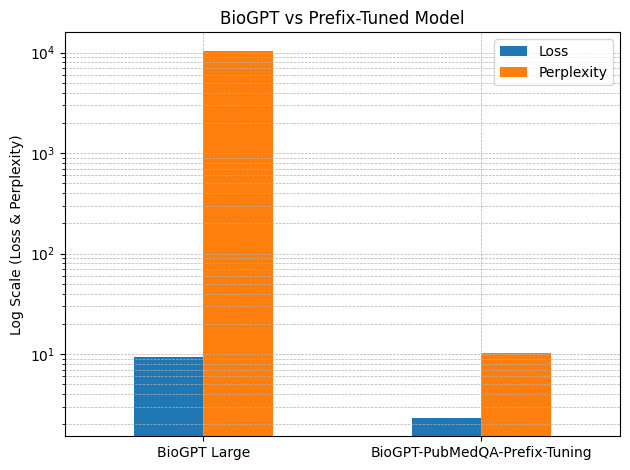

In [43]:
import matplotlib.pyplot as plt

data.T.plot(kind='bar', logy=True)
plt.title("BioGPT vs Prefix-Tuned Model")
plt.ylabel("Log Scale (Loss & Perplexity)")
plt.xticks(rotation=0)
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.tight_layout()
plt.show()


# Assess Overfitting

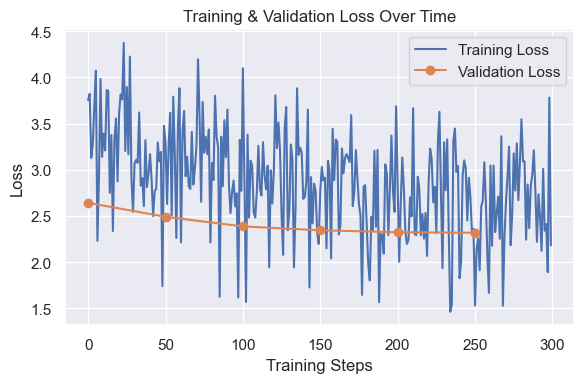

In [45]:
import matplotlib.pyplot as plt
import seaborn as sns

# Use plot styling from seaborn
sns.set(style='darkgrid')

# Increase the plot size and font size
plt.rcParams["figure.figsize"] = (6, 4)
plt.rcParams["font.size"] = 12

# Plot the learning curve
plt.plot(loss_train, label="Training Loss")
plt.plot(range(0, len(loss_train), len(loss_train)//len(loss_eval)), loss_eval, label="Validation Loss", marker='o')

# Label the plot
plt.title("Training & Validation Loss Over Time")
plt.xlabel("Training Steps")
plt.ylabel("Loss")
plt.legend()
plt.tight_layout()
plt.show()


# Model Testing

In [46]:
user_input = "what are the symptoms of hypertension?"
print(user_input)

sentence = 'Question: ' + user_input + '. Answer: '

inputs = tokenizer(sentence, return_tensors="pt")
print(inputs)

output = model.generate(**inputs, max_length=200, num_return_sequences=1, no_repeat_ngram_size=2, repetition_penalty=1.5, top_p=0.92, temperature=1.0)
generated_text = tokenizer.decode(output[0], skip_special_tokens=True)
generated_text

The following generation flags are not valid and may be ignored: ['top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


what are the symptoms of hypertension?
{'input_ids': tensor([[    2,  4790, 20925,    20,  1994,    31,     6,   367,     5,   936,
           927,     4,  1955,  6006,   783,    20]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}


'Question: what are the symptoms of hypertension?. Answer: The prevalence and impact on quality-adjusted life years in patients with mild to moderate essential arterial hypertension--results from a cross sectional study (EPITHEE), Germany / Austria.'

In [49]:
from transformers import pipeline

qa = pipeline("question-answering", model="deepset/roberta-base-squad2")

result = qa({
    "question": "What are the symptoms of hypertension?",
    "context": "Symptoms of hypertension may include headaches, dizziness, shortness of breath, nosebleeds, and chest pain. However, many individuals do not exhibit symptoms."
})

print("Answer:", result["answer"])



Error while downloading from https://cdn-lfs.hf.co/deepset/roberta-base-squad2/ac5db66fdcfecb400345d09787b71009d60805ef9883451071669cf951b5e2c7?response-content-disposition=inline%3B+filename*%3DUTF-8%27%27model.safetensors%3B+filename%3D%22model.safetensors%22%3B&Expires=1751742416&Policy=eyJTdGF0ZW1lbnQiOlt7IkNvbmRpdGlvbiI6eyJEYXRlTGVzc1RoYW4iOnsiQVdTOkVwb2NoVGltZSI6MTc1MTc0MjQxNn19LCJSZXNvdXJjZSI6Imh0dHBzOi8vY2RuLWxmcy5oZi5jby9kZWVwc2V0L3JvYmVydGEtYmFzZS1zcXVhZDIvYWM1ZGI2NmZkY2ZlY2I0MDAzNDVkMDk3ODdiNzEwMDlkNjA4MDVlZjk4ODM0NTEwNzE2NjljZjk1MWI1ZTJjNz9yZXNwb25zZS1jb250ZW50LWRpc3Bvc2l0aW9uPSoifV19&Signature=qb8jc159e1c8yyMpSz%7E850tlaQIkauCgj4tXftDssKb9fe0wr2X6uuZtrQy40S-rTiXXTC%7E5w0nRHUvTg5TrvXXfi6JKXvbF0CjuXFfRWs1PxpnKhvMR6NVP5qF5MJjNZn-2gixLlTZJw1ZhsOzzJrg2-ZloWOI2A6F9stN61M4V53QAiUxkPUNCeF06-ps98nlhWJ-7VDogeuvDJfLR7cTIOBqDHDv2PBg9PmeLpzzvocH3stM0nxF2EA9htnLhbBuJRuoBBofKVbmCsjrMbbuWAQLl7RvrZWFLYnjdaseto0vva2dGJ89Ci8rZqPMigwxAZs6OPB0u8MpG3NhmPQ__&Key-Pair-Id=K3RPWS32NSSJCE: HTTPSConn

ValueError: Could not load model deepset/roberta-base-squad2 with any of the following classes: (<class 'transformers.models.auto.modeling_auto.AutoModelForQuestionAnswering'>, <class 'transformers.models.roberta.modeling_roberta.RobertaForQuestionAnswering'>). See the original errors:

while loading with AutoModelForQuestionAnswering, an error is thrown:
Traceback (most recent call last):
  File "/Users/bhavanapoli/AI-HealthBoard/.venv/lib/python3.10/site-packages/urllib3/response.py", line 779, in _error_catcher
    yield
  File "/Users/bhavanapoli/AI-HealthBoard/.venv/lib/python3.10/site-packages/urllib3/response.py", line 904, in _raw_read
    data = self._fp_read(amt, read1=read1) if not fp_closed else b""
  File "/Users/bhavanapoli/AI-HealthBoard/.venv/lib/python3.10/site-packages/urllib3/response.py", line 887, in _fp_read
    return self._fp.read(amt) if amt is not None else self._fp.read()
  File "/Users/bhavanapoli/.pyenv/versions/3.10.13/lib/python3.10/http/client.py", line 466, in read
    s = self.fp.read(amt)
  File "/Users/bhavanapoli/.pyenv/versions/3.10.13/lib/python3.10/socket.py", line 705, in readinto
    return self._sock.recv_into(b)
  File "/Users/bhavanapoli/.pyenv/versions/3.10.13/lib/python3.10/ssl.py", line 1307, in recv_into
    return self.read(nbytes, buffer)
  File "/Users/bhavanapoli/.pyenv/versions/3.10.13/lib/python3.10/ssl.py", line 1163, in read
    return self._sslobj.read(len, buffer)
TimeoutError: The read operation timed out

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/Users/bhavanapoli/AI-HealthBoard/.venv/lib/python3.10/site-packages/requests/models.py", line 820, in generate
    yield from self.raw.stream(chunk_size, decode_content=True)
  File "/Users/bhavanapoli/AI-HealthBoard/.venv/lib/python3.10/site-packages/urllib3/response.py", line 1091, in stream
    data = self.read(amt=amt, decode_content=decode_content)
  File "/Users/bhavanapoli/AI-HealthBoard/.venv/lib/python3.10/site-packages/urllib3/response.py", line 980, in read
    data = self._raw_read(amt)
  File "/Users/bhavanapoli/AI-HealthBoard/.venv/lib/python3.10/site-packages/urllib3/response.py", line 903, in _raw_read
    with self._error_catcher():
  File "/Users/bhavanapoli/.pyenv/versions/3.10.13/lib/python3.10/contextlib.py", line 153, in __exit__
    self.gen.throw(typ, value, traceback)
  File "/Users/bhavanapoli/AI-HealthBoard/.venv/lib/python3.10/site-packages/urllib3/response.py", line 784, in _error_catcher
    raise ReadTimeoutError(self._pool, None, "Read timed out.") from e  # type: ignore[arg-type]
urllib3.exceptions.ReadTimeoutError: HTTPSConnectionPool(host='cdn-lfs.hf.co', port=443): Read timed out.

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/bhavanapoli/AI-HealthBoard/.venv/lib/python3.10/site-packages/huggingface_hub/file_download.py", line 494, in http_get
    for chunk in r.iter_content(chunk_size=constants.DOWNLOAD_CHUNK_SIZE):
  File "/Users/bhavanapoli/AI-HealthBoard/.venv/lib/python3.10/site-packages/requests/models.py", line 826, in generate
    raise ConnectionError(e)
requests.exceptions.ConnectionError: HTTPSConnectionPool(host='cdn-lfs.hf.co', port=443): Read timed out.

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/bhavanapoli/AI-HealthBoard/.venv/lib/python3.10/site-packages/urllib3/connection.py", line 198, in _new_conn
    sock = connection.create_connection(
  File "/Users/bhavanapoli/AI-HealthBoard/.venv/lib/python3.10/site-packages/urllib3/util/connection.py", line 85, in create_connection
    raise err
  File "/Users/bhavanapoli/AI-HealthBoard/.venv/lib/python3.10/site-packages/urllib3/util/connection.py", line 73, in create_connection
    sock.connect(sa)
TimeoutError: timed out

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/Users/bhavanapoli/AI-HealthBoard/.venv/lib/python3.10/site-packages/urllib3/connectionpool.py", line 787, in urlopen
    response = self._make_request(
  File "/Users/bhavanapoli/AI-HealthBoard/.venv/lib/python3.10/site-packages/urllib3/connectionpool.py", line 488, in _make_request
    raise new_e
  File "/Users/bhavanapoli/AI-HealthBoard/.venv/lib/python3.10/site-packages/urllib3/connectionpool.py", line 464, in _make_request
    self._validate_conn(conn)
  File "/Users/bhavanapoli/AI-HealthBoard/.venv/lib/python3.10/site-packages/urllib3/connectionpool.py", line 1093, in _validate_conn
    conn.connect()
  File "/Users/bhavanapoli/AI-HealthBoard/.venv/lib/python3.10/site-packages/urllib3/connection.py", line 753, in connect
    self.sock = sock = self._new_conn()
  File "/Users/bhavanapoli/AI-HealthBoard/.venv/lib/python3.10/site-packages/urllib3/connection.py", line 207, in _new_conn
    raise ConnectTimeoutError(
urllib3.exceptions.ConnectTimeoutError: (<urllib3.connection.HTTPSConnection object at 0x137224a90>, 'Connection to cdn-lfs.hf.co timed out. (connect timeout=10)')

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/Users/bhavanapoli/AI-HealthBoard/.venv/lib/python3.10/site-packages/requests/adapters.py", line 667, in send
    resp = conn.urlopen(
  File "/Users/bhavanapoli/AI-HealthBoard/.venv/lib/python3.10/site-packages/urllib3/connectionpool.py", line 841, in urlopen
    retries = retries.increment(
  File "/Users/bhavanapoli/AI-HealthBoard/.venv/lib/python3.10/site-packages/urllib3/util/retry.py", line 519, in increment
    raise MaxRetryError(_pool, url, reason) from reason  # type: ignore[arg-type]
urllib3.exceptions.MaxRetryError: HTTPSConnectionPool(host='cdn-lfs.hf.co', port=443): Max retries exceeded with url: /deepset/roberta-base-squad2/ac5db66fdcfecb400345d09787b71009d60805ef9883451071669cf951b5e2c7?response-content-disposition=inline%3B+filename*%3DUTF-8%27%27model.safetensors%3B+filename%3D%22model.safetensors%22%3B&Expires=1751742416&Policy=eyJTdGF0ZW1lbnQiOlt7IkNvbmRpdGlvbiI6eyJEYXRlTGVzc1RoYW4iOnsiQVdTOkVwb2NoVGltZSI6MTc1MTc0MjQxNn19LCJSZXNvdXJjZSI6Imh0dHBzOi8vY2RuLWxmcy5oZi5jby9kZWVwc2V0L3JvYmVydGEtYmFzZS1zcXVhZDIvYWM1ZGI2NmZkY2ZlY2I0MDAzNDVkMDk3ODdiNzEwMDlkNjA4MDVlZjk4ODM0NTEwNzE2NjljZjk1MWI1ZTJjNz9yZXNwb25zZS1jb250ZW50LWRpc3Bvc2l0aW9uPSoifV19&Signature=qb8jc159e1c8yyMpSz~850tlaQIkauCgj4tXftDssKb9fe0wr2X6uuZtrQy40S-rTiXXTC~5w0nRHUvTg5TrvXXfi6JKXvbF0CjuXFfRWs1PxpnKhvMR6NVP5qF5MJjNZn-2gixLlTZJw1ZhsOzzJrg2-ZloWOI2A6F9stN61M4V53QAiUxkPUNCeF06-ps98nlhWJ-7VDogeuvDJfLR7cTIOBqDHDv2PBg9PmeLpzzvocH3stM0nxF2EA9htnLhbBuJRuoBBofKVbmCsjrMbbuWAQLl7RvrZWFLYnjdaseto0vva2dGJ89Ci8rZqPMigwxAZs6OPB0u8MpG3NhmPQ__&Key-Pair-Id=K3RPWS32NSSJCE (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0x137224a90>, 'Connection to cdn-lfs.hf.co timed out. (connect timeout=10)'))

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/bhavanapoli/AI-HealthBoard/.venv/lib/python3.10/site-packages/transformers/pipelines/base.py", line 292, in infer_framework_load_model
    model = model_class.from_pretrained(model, **kwargs)
  File "/Users/bhavanapoli/AI-HealthBoard/.venv/lib/python3.10/site-packages/transformers/models/auto/auto_factory.py", line 600, in from_pretrained
    return model_class.from_pretrained(
  File "/Users/bhavanapoli/AI-HealthBoard/.venv/lib/python3.10/site-packages/transformers/modeling_utils.py", line 311, in _wrapper
    return func(*args, **kwargs)
  File "/Users/bhavanapoli/AI-HealthBoard/.venv/lib/python3.10/site-packages/transformers/modeling_utils.py", line 4680, in from_pretrained
    checkpoint_files, sharded_metadata = _get_resolved_checkpoint_files(
  File "/Users/bhavanapoli/AI-HealthBoard/.venv/lib/python3.10/site-packages/transformers/modeling_utils.py", line 1137, in _get_resolved_checkpoint_files
    resolved_archive_file = cached_file(pretrained_model_name_or_path, filename, **cached_file_kwargs)
  File "/Users/bhavanapoli/AI-HealthBoard/.venv/lib/python3.10/site-packages/transformers/utils/hub.py", line 312, in cached_file
    file = cached_files(path_or_repo_id=path_or_repo_id, filenames=[filename], **kwargs)
  File "/Users/bhavanapoli/AI-HealthBoard/.venv/lib/python3.10/site-packages/transformers/utils/hub.py", line 557, in cached_files
    raise e
  File "/Users/bhavanapoli/AI-HealthBoard/.venv/lib/python3.10/site-packages/transformers/utils/hub.py", line 470, in cached_files
    hf_hub_download(
  File "/Users/bhavanapoli/AI-HealthBoard/.venv/lib/python3.10/site-packages/huggingface_hub/utils/_validators.py", line 114, in _inner_fn
    return fn(*args, **kwargs)
  File "/Users/bhavanapoli/AI-HealthBoard/.venv/lib/python3.10/site-packages/huggingface_hub/file_download.py", line 1008, in hf_hub_download
    return _hf_hub_download_to_cache_dir(
  File "/Users/bhavanapoli/AI-HealthBoard/.venv/lib/python3.10/site-packages/huggingface_hub/file_download.py", line 1161, in _hf_hub_download_to_cache_dir
    _download_to_tmp_and_move(
  File "/Users/bhavanapoli/AI-HealthBoard/.venv/lib/python3.10/site-packages/huggingface_hub/file_download.py", line 1725, in _download_to_tmp_and_move
    http_get(
  File "/Users/bhavanapoli/AI-HealthBoard/.venv/lib/python3.10/site-packages/huggingface_hub/file_download.py", line 511, in http_get
    return http_get(
  File "/Users/bhavanapoli/AI-HealthBoard/.venv/lib/python3.10/site-packages/huggingface_hub/file_download.py", line 420, in http_get
    r = _request_wrapper(
  File "/Users/bhavanapoli/AI-HealthBoard/.venv/lib/python3.10/site-packages/huggingface_hub/file_download.py", line 309, in _request_wrapper
    response = http_backoff(method=method, url=url, **params, retry_on_exceptions=(), retry_on_status_codes=(429,))
  File "/Users/bhavanapoli/AI-HealthBoard/.venv/lib/python3.10/site-packages/huggingface_hub/utils/_http.py", line 310, in http_backoff
    response = session.request(method=method, url=url, **kwargs)
  File "/Users/bhavanapoli/AI-HealthBoard/.venv/lib/python3.10/site-packages/requests/sessions.py", line 589, in request
    resp = self.send(prep, **send_kwargs)
  File "/Users/bhavanapoli/AI-HealthBoard/.venv/lib/python3.10/site-packages/requests/sessions.py", line 703, in send
    r = adapter.send(request, **kwargs)
  File "/Users/bhavanapoli/AI-HealthBoard/.venv/lib/python3.10/site-packages/huggingface_hub/utils/_http.py", line 96, in send
    return super().send(request, *args, **kwargs)
  File "/Users/bhavanapoli/AI-HealthBoard/.venv/lib/python3.10/site-packages/requests/adapters.py", line 688, in send
    raise ConnectTimeout(e, request=request)
requests.exceptions.ConnectTimeout: (MaxRetryError("HTTPSConnectionPool(host='cdn-lfs.hf.co', port=443): Max retries exceeded with url: /deepset/roberta-base-squad2/ac5db66fdcfecb400345d09787b71009d60805ef9883451071669cf951b5e2c7?response-content-disposition=inline%3B+filename*%3DUTF-8%27%27model.safetensors%3B+filename%3D%22model.safetensors%22%3B&Expires=1751742416&Policy=eyJTdGF0ZW1lbnQiOlt7IkNvbmRpdGlvbiI6eyJEYXRlTGVzc1RoYW4iOnsiQVdTOkVwb2NoVGltZSI6MTc1MTc0MjQxNn19LCJSZXNvdXJjZSI6Imh0dHBzOi8vY2RuLWxmcy5oZi5jby9kZWVwc2V0L3JvYmVydGEtYmFzZS1zcXVhZDIvYWM1ZGI2NmZkY2ZlY2I0MDAzNDVkMDk3ODdiNzEwMDlkNjA4MDVlZjk4ODM0NTEwNzE2NjljZjk1MWI1ZTJjNz9yZXNwb25zZS1jb250ZW50LWRpc3Bvc2l0aW9uPSoifV19&Signature=qb8jc159e1c8yyMpSz~850tlaQIkauCgj4tXftDssKb9fe0wr2X6uuZtrQy40S-rTiXXTC~5w0nRHUvTg5TrvXXfi6JKXvbF0CjuXFfRWs1PxpnKhvMR6NVP5qF5MJjNZn-2gixLlTZJw1ZhsOzzJrg2-ZloWOI2A6F9stN61M4V53QAiUxkPUNCeF06-ps98nlhWJ-7VDogeuvDJfLR7cTIOBqDHDv2PBg9PmeLpzzvocH3stM0nxF2EA9htnLhbBuJRuoBBofKVbmCsjrMbbuWAQLl7RvrZWFLYnjdaseto0vva2dGJ89Ci8rZqPMigwxAZs6OPB0u8MpG3NhmPQ__&Key-Pair-Id=K3RPWS32NSSJCE (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0x137224a90>, 'Connection to cdn-lfs.hf.co timed out. (connect timeout=10)'))"), '(Request ID: de5005ff-5845-4338-b5e2-6340699341f1)')

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/bhavanapoli/AI-HealthBoard/.venv/lib/python3.10/site-packages/urllib3/connection.py", line 198, in _new_conn
    sock = connection.create_connection(
  File "/Users/bhavanapoli/AI-HealthBoard/.venv/lib/python3.10/site-packages/urllib3/util/connection.py", line 85, in create_connection
    raise err
  File "/Users/bhavanapoli/AI-HealthBoard/.venv/lib/python3.10/site-packages/urllib3/util/connection.py", line 73, in create_connection
    sock.connect(sa)
TimeoutError: timed out

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/Users/bhavanapoli/AI-HealthBoard/.venv/lib/python3.10/site-packages/urllib3/connectionpool.py", line 787, in urlopen
    response = self._make_request(
  File "/Users/bhavanapoli/AI-HealthBoard/.venv/lib/python3.10/site-packages/urllib3/connectionpool.py", line 488, in _make_request
    raise new_e
  File "/Users/bhavanapoli/AI-HealthBoard/.venv/lib/python3.10/site-packages/urllib3/connectionpool.py", line 464, in _make_request
    self._validate_conn(conn)
  File "/Users/bhavanapoli/AI-HealthBoard/.venv/lib/python3.10/site-packages/urllib3/connectionpool.py", line 1093, in _validate_conn
    conn.connect()
  File "/Users/bhavanapoli/AI-HealthBoard/.venv/lib/python3.10/site-packages/urllib3/connection.py", line 753, in connect
    self.sock = sock = self._new_conn()
  File "/Users/bhavanapoli/AI-HealthBoard/.venv/lib/python3.10/site-packages/urllib3/connection.py", line 207, in _new_conn
    raise ConnectTimeoutError(
urllib3.exceptions.ConnectTimeoutError: (<urllib3.connection.HTTPSConnection object at 0x126b09780>, 'Connection to cdn-lfs.hf.co timed out. (connect timeout=10)')

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/Users/bhavanapoli/AI-HealthBoard/.venv/lib/python3.10/site-packages/requests/adapters.py", line 667, in send
    resp = conn.urlopen(
  File "/Users/bhavanapoli/AI-HealthBoard/.venv/lib/python3.10/site-packages/urllib3/connectionpool.py", line 841, in urlopen
    retries = retries.increment(
  File "/Users/bhavanapoli/AI-HealthBoard/.venv/lib/python3.10/site-packages/urllib3/util/retry.py", line 519, in increment
    raise MaxRetryError(_pool, url, reason) from reason  # type: ignore[arg-type]
urllib3.exceptions.MaxRetryError: HTTPSConnectionPool(host='cdn-lfs.hf.co', port=443): Max retries exceeded with url: /deepset/roberta-base-squad2/ac5db66fdcfecb400345d09787b71009d60805ef9883451071669cf951b5e2c7?response-content-disposition=inline%3B+filename*%3DUTF-8%27%27model.safetensors%3B+filename%3D%22model.safetensors%22%3B&Expires=1751742641&Policy=eyJTdGF0ZW1lbnQiOlt7IkNvbmRpdGlvbiI6eyJEYXRlTGVzc1RoYW4iOnsiQVdTOkVwb2NoVGltZSI6MTc1MTc0MjY0MX19LCJSZXNvdXJjZSI6Imh0dHBzOi8vY2RuLWxmcy5oZi5jby9kZWVwc2V0L3JvYmVydGEtYmFzZS1zcXVhZDIvYWM1ZGI2NmZkY2ZlY2I0MDAzNDVkMDk3ODdiNzEwMDlkNjA4MDVlZjk4ODM0NTEwNzE2NjljZjk1MWI1ZTJjNz9yZXNwb25zZS1jb250ZW50LWRpc3Bvc2l0aW9uPSoifV19&Signature=oFNSRcKP~9ZkgzXm8o9CL5mdkCV452i~8NvktVf606ROY1cqzP9EcADVZ8qtvClCD3Tah0jZ3kSwiN0fBX0nk5o6wiE799VzVqUlY98pk-8RxggnoSCtWpONEeO4YcHIFjoh~tovFkT8mAwtkpDuqt71VHmqVrvLOM-UiEQ7CFBXsc4dJ9vV45uM4BZrJ4YfolHta191IKQ2sPBIQZBVKvDhdncINf26rgWLJAJayeX5wSOZBXaFAcbIh80PeDzKpI-3nO4IfB99qObunvmHrEI8-nqpcJaWhqQt4-BvKBw2ylHyI57ni3~bEY-DaoTAbpF54ZT9NuWJrekNigdFqg__&Key-Pair-Id=K3RPWS32NSSJCE (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0x126b09780>, 'Connection to cdn-lfs.hf.co timed out. (connect timeout=10)'))

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/bhavanapoli/AI-HealthBoard/.venv/lib/python3.10/site-packages/transformers/pipelines/base.py", line 310, in infer_framework_load_model
    model = model_class.from_pretrained(model, **fp32_kwargs)
  File "/Users/bhavanapoli/AI-HealthBoard/.venv/lib/python3.10/site-packages/transformers/models/auto/auto_factory.py", line 600, in from_pretrained
    return model_class.from_pretrained(
  File "/Users/bhavanapoli/AI-HealthBoard/.venv/lib/python3.10/site-packages/transformers/modeling_utils.py", line 311, in _wrapper
    return func(*args, **kwargs)
  File "/Users/bhavanapoli/AI-HealthBoard/.venv/lib/python3.10/site-packages/transformers/modeling_utils.py", line 4680, in from_pretrained
    checkpoint_files, sharded_metadata = _get_resolved_checkpoint_files(
  File "/Users/bhavanapoli/AI-HealthBoard/.venv/lib/python3.10/site-packages/transformers/modeling_utils.py", line 1137, in _get_resolved_checkpoint_files
    resolved_archive_file = cached_file(pretrained_model_name_or_path, filename, **cached_file_kwargs)
  File "/Users/bhavanapoli/AI-HealthBoard/.venv/lib/python3.10/site-packages/transformers/utils/hub.py", line 312, in cached_file
    file = cached_files(path_or_repo_id=path_or_repo_id, filenames=[filename], **kwargs)
  File "/Users/bhavanapoli/AI-HealthBoard/.venv/lib/python3.10/site-packages/transformers/utils/hub.py", line 557, in cached_files
    raise e
  File "/Users/bhavanapoli/AI-HealthBoard/.venv/lib/python3.10/site-packages/transformers/utils/hub.py", line 470, in cached_files
    hf_hub_download(
  File "/Users/bhavanapoli/AI-HealthBoard/.venv/lib/python3.10/site-packages/huggingface_hub/utils/_validators.py", line 114, in _inner_fn
    return fn(*args, **kwargs)
  File "/Users/bhavanapoli/AI-HealthBoard/.venv/lib/python3.10/site-packages/huggingface_hub/file_download.py", line 1008, in hf_hub_download
    return _hf_hub_download_to_cache_dir(
  File "/Users/bhavanapoli/AI-HealthBoard/.venv/lib/python3.10/site-packages/huggingface_hub/file_download.py", line 1161, in _hf_hub_download_to_cache_dir
    _download_to_tmp_and_move(
  File "/Users/bhavanapoli/AI-HealthBoard/.venv/lib/python3.10/site-packages/huggingface_hub/file_download.py", line 1725, in _download_to_tmp_and_move
    http_get(
  File "/Users/bhavanapoli/AI-HealthBoard/.venv/lib/python3.10/site-packages/huggingface_hub/file_download.py", line 420, in http_get
    r = _request_wrapper(
  File "/Users/bhavanapoli/AI-HealthBoard/.venv/lib/python3.10/site-packages/huggingface_hub/file_download.py", line 309, in _request_wrapper
    response = http_backoff(method=method, url=url, **params, retry_on_exceptions=(), retry_on_status_codes=(429,))
  File "/Users/bhavanapoli/AI-HealthBoard/.venv/lib/python3.10/site-packages/huggingface_hub/utils/_http.py", line 310, in http_backoff
    response = session.request(method=method, url=url, **kwargs)
  File "/Users/bhavanapoli/AI-HealthBoard/.venv/lib/python3.10/site-packages/requests/sessions.py", line 589, in request
    resp = self.send(prep, **send_kwargs)
  File "/Users/bhavanapoli/AI-HealthBoard/.venv/lib/python3.10/site-packages/requests/sessions.py", line 703, in send
    r = adapter.send(request, **kwargs)
  File "/Users/bhavanapoli/AI-HealthBoard/.venv/lib/python3.10/site-packages/huggingface_hub/utils/_http.py", line 96, in send
    return super().send(request, *args, **kwargs)
  File "/Users/bhavanapoli/AI-HealthBoard/.venv/lib/python3.10/site-packages/requests/adapters.py", line 688, in send
    raise ConnectTimeout(e, request=request)
requests.exceptions.ConnectTimeout: (MaxRetryError("HTTPSConnectionPool(host='cdn-lfs.hf.co', port=443): Max retries exceeded with url: /deepset/roberta-base-squad2/ac5db66fdcfecb400345d09787b71009d60805ef9883451071669cf951b5e2c7?response-content-disposition=inline%3B+filename*%3DUTF-8%27%27model.safetensors%3B+filename%3D%22model.safetensors%22%3B&Expires=1751742641&Policy=eyJTdGF0ZW1lbnQiOlt7IkNvbmRpdGlvbiI6eyJEYXRlTGVzc1RoYW4iOnsiQVdTOkVwb2NoVGltZSI6MTc1MTc0MjY0MX19LCJSZXNvdXJjZSI6Imh0dHBzOi8vY2RuLWxmcy5oZi5jby9kZWVwc2V0L3JvYmVydGEtYmFzZS1zcXVhZDIvYWM1ZGI2NmZkY2ZlY2I0MDAzNDVkMDk3ODdiNzEwMDlkNjA4MDVlZjk4ODM0NTEwNzE2NjljZjk1MWI1ZTJjNz9yZXNwb25zZS1jb250ZW50LWRpc3Bvc2l0aW9uPSoifV19&Signature=oFNSRcKP~9ZkgzXm8o9CL5mdkCV452i~8NvktVf606ROY1cqzP9EcADVZ8qtvClCD3Tah0jZ3kSwiN0fBX0nk5o6wiE799VzVqUlY98pk-8RxggnoSCtWpONEeO4YcHIFjoh~tovFkT8mAwtkpDuqt71VHmqVrvLOM-UiEQ7CFBXsc4dJ9vV45uM4BZrJ4YfolHta191IKQ2sPBIQZBVKvDhdncINf26rgWLJAJayeX5wSOZBXaFAcbIh80PeDzKpI-3nO4IfB99qObunvmHrEI8-nqpcJaWhqQt4-BvKBw2ylHyI57ni3~bEY-DaoTAbpF54ZT9NuWJrekNigdFqg__&Key-Pair-Id=K3RPWS32NSSJCE (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0x126b09780>, 'Connection to cdn-lfs.hf.co timed out. (connect timeout=10)'))"), '(Request ID: 9d19e090-285f-4fbb-8764-5edc258e21c6)')

while loading with RobertaForQuestionAnswering, an error is thrown:
Traceback (most recent call last):
  File "/Users/bhavanapoli/AI-HealthBoard/.venv/lib/python3.10/site-packages/urllib3/connection.py", line 198, in _new_conn
    sock = connection.create_connection(
  File "/Users/bhavanapoli/AI-HealthBoard/.venv/lib/python3.10/site-packages/urllib3/util/connection.py", line 85, in create_connection
    raise err
  File "/Users/bhavanapoli/AI-HealthBoard/.venv/lib/python3.10/site-packages/urllib3/util/connection.py", line 73, in create_connection
    sock.connect(sa)
TimeoutError: timed out

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/Users/bhavanapoli/AI-HealthBoard/.venv/lib/python3.10/site-packages/urllib3/connectionpool.py", line 787, in urlopen
    response = self._make_request(
  File "/Users/bhavanapoli/AI-HealthBoard/.venv/lib/python3.10/site-packages/urllib3/connectionpool.py", line 488, in _make_request
    raise new_e
  File "/Users/bhavanapoli/AI-HealthBoard/.venv/lib/python3.10/site-packages/urllib3/connectionpool.py", line 464, in _make_request
    self._validate_conn(conn)
  File "/Users/bhavanapoli/AI-HealthBoard/.venv/lib/python3.10/site-packages/urllib3/connectionpool.py", line 1093, in _validate_conn
    conn.connect()
  File "/Users/bhavanapoli/AI-HealthBoard/.venv/lib/python3.10/site-packages/urllib3/connection.py", line 753, in connect
    self.sock = sock = self._new_conn()
  File "/Users/bhavanapoli/AI-HealthBoard/.venv/lib/python3.10/site-packages/urllib3/connection.py", line 207, in _new_conn
    raise ConnectTimeoutError(
urllib3.exceptions.ConnectTimeoutError: (<urllib3.connection.HTTPSConnection object at 0x126b0a650>, 'Connection to cdn-lfs.hf.co timed out. (connect timeout=10)')

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/Users/bhavanapoli/AI-HealthBoard/.venv/lib/python3.10/site-packages/requests/adapters.py", line 667, in send
    resp = conn.urlopen(
  File "/Users/bhavanapoli/AI-HealthBoard/.venv/lib/python3.10/site-packages/urllib3/connectionpool.py", line 841, in urlopen
    retries = retries.increment(
  File "/Users/bhavanapoli/AI-HealthBoard/.venv/lib/python3.10/site-packages/urllib3/util/retry.py", line 519, in increment
    raise MaxRetryError(_pool, url, reason) from reason  # type: ignore[arg-type]
urllib3.exceptions.MaxRetryError: HTTPSConnectionPool(host='cdn-lfs.hf.co', port=443): Max retries exceeded with url: /deepset/roberta-base-squad2/e0b64ccefc1bcb569b604baea27eb873e5482fdf6eb3ceff1fb5368397db5aed?response-content-disposition=inline%3B+filename*%3DUTF-8%27%27pytorch_model.bin%3B+filename%3D%22pytorch_model.bin%22%3B&response-content-type=application%2Foctet-stream&Expires=1751742362&Policy=eyJTdGF0ZW1lbnQiOlt7IkNvbmRpdGlvbiI6eyJEYXRlTGVzc1RoYW4iOnsiQVdTOkVwb2NoVGltZSI6MTc1MTc0MjM2Mn19LCJSZXNvdXJjZSI6Imh0dHBzOi8vY2RuLWxmcy5oZi5jby9kZWVwc2V0L3JvYmVydGEtYmFzZS1zcXVhZDIvZTBiNjRjY2VmYzFiY2I1NjliNjA0YmFlYTI3ZWI4NzNlNTQ4MmZkZjZlYjNjZWZmMWZiNTM2ODM5N2RiNWFlZD9yZXNwb25zZS1jb250ZW50LWRpc3Bvc2l0aW9uPSomcmVzcG9uc2UtY29udGVudC10eXBlPSoifV19&Signature=IM8xnMl4NJxfB7J6V4ud1OfMhBIViaY6fRcbgCkMo5r6CKoUCUYmAkh5yGpZTsplSC-yUHIsAEnGyv4HQRO-KlhHbRziMOQBHUhMxnwNChz3buczO5Ssv2jOqXHgXur4eo5yX82a3TkzaN9N2zqFuBbK2UQjh7FLB2V3F~RBWz91ROqQ3aF4YP9phpNWdRP3AIfQvS5wGEhTf8EuuZ4-~RiwnJ15kaxRCGAX0jMwEeOH9A757M6GWFBqj9MOSfMWfsPBjkHzNabTN-rsniwcbr6EQdrMpc8Qf78hlH~x1bEUfqYN3xtCIZOXCra8w0x25VExKnWsAlTTj6tZCcaXPg__&Key-Pair-Id=K3RPWS32NSSJCE (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0x126b0a650>, 'Connection to cdn-lfs.hf.co timed out. (connect timeout=10)'))

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/bhavanapoli/AI-HealthBoard/.venv/lib/python3.10/site-packages/transformers/pipelines/base.py", line 292, in infer_framework_load_model
    model = model_class.from_pretrained(model, **kwargs)
  File "/Users/bhavanapoli/AI-HealthBoard/.venv/lib/python3.10/site-packages/transformers/modeling_utils.py", line 311, in _wrapper
    return func(*args, **kwargs)
  File "/Users/bhavanapoli/AI-HealthBoard/.venv/lib/python3.10/site-packages/transformers/modeling_utils.py", line 4680, in from_pretrained
    checkpoint_files, sharded_metadata = _get_resolved_checkpoint_files(
  File "/Users/bhavanapoli/AI-HealthBoard/.venv/lib/python3.10/site-packages/transformers/modeling_utils.py", line 1166, in _get_resolved_checkpoint_files
    resolved_archive_file = cached_file(
  File "/Users/bhavanapoli/AI-HealthBoard/.venv/lib/python3.10/site-packages/transformers/utils/hub.py", line 312, in cached_file
    file = cached_files(path_or_repo_id=path_or_repo_id, filenames=[filename], **kwargs)
  File "/Users/bhavanapoli/AI-HealthBoard/.venv/lib/python3.10/site-packages/transformers/utils/hub.py", line 557, in cached_files
    raise e
  File "/Users/bhavanapoli/AI-HealthBoard/.venv/lib/python3.10/site-packages/transformers/utils/hub.py", line 470, in cached_files
    hf_hub_download(
  File "/Users/bhavanapoli/AI-HealthBoard/.venv/lib/python3.10/site-packages/huggingface_hub/utils/_validators.py", line 114, in _inner_fn
    return fn(*args, **kwargs)
  File "/Users/bhavanapoli/AI-HealthBoard/.venv/lib/python3.10/site-packages/huggingface_hub/file_download.py", line 1008, in hf_hub_download
    return _hf_hub_download_to_cache_dir(
  File "/Users/bhavanapoli/AI-HealthBoard/.venv/lib/python3.10/site-packages/huggingface_hub/file_download.py", line 1161, in _hf_hub_download_to_cache_dir
    _download_to_tmp_and_move(
  File "/Users/bhavanapoli/AI-HealthBoard/.venv/lib/python3.10/site-packages/huggingface_hub/file_download.py", line 1725, in _download_to_tmp_and_move
    http_get(
  File "/Users/bhavanapoli/AI-HealthBoard/.venv/lib/python3.10/site-packages/huggingface_hub/file_download.py", line 420, in http_get
    r = _request_wrapper(
  File "/Users/bhavanapoli/AI-HealthBoard/.venv/lib/python3.10/site-packages/huggingface_hub/file_download.py", line 309, in _request_wrapper
    response = http_backoff(method=method, url=url, **params, retry_on_exceptions=(), retry_on_status_codes=(429,))
  File "/Users/bhavanapoli/AI-HealthBoard/.venv/lib/python3.10/site-packages/huggingface_hub/utils/_http.py", line 310, in http_backoff
    response = session.request(method=method, url=url, **kwargs)
  File "/Users/bhavanapoli/AI-HealthBoard/.venv/lib/python3.10/site-packages/requests/sessions.py", line 589, in request
    resp = self.send(prep, **send_kwargs)
  File "/Users/bhavanapoli/AI-HealthBoard/.venv/lib/python3.10/site-packages/requests/sessions.py", line 703, in send
    r = adapter.send(request, **kwargs)
  File "/Users/bhavanapoli/AI-HealthBoard/.venv/lib/python3.10/site-packages/huggingface_hub/utils/_http.py", line 96, in send
    return super().send(request, *args, **kwargs)
  File "/Users/bhavanapoli/AI-HealthBoard/.venv/lib/python3.10/site-packages/requests/adapters.py", line 688, in send
    raise ConnectTimeout(e, request=request)
requests.exceptions.ConnectTimeout: (MaxRetryError("HTTPSConnectionPool(host='cdn-lfs.hf.co', port=443): Max retries exceeded with url: /deepset/roberta-base-squad2/e0b64ccefc1bcb569b604baea27eb873e5482fdf6eb3ceff1fb5368397db5aed?response-content-disposition=inline%3B+filename*%3DUTF-8%27%27pytorch_model.bin%3B+filename%3D%22pytorch_model.bin%22%3B&response-content-type=application%2Foctet-stream&Expires=1751742362&Policy=eyJTdGF0ZW1lbnQiOlt7IkNvbmRpdGlvbiI6eyJEYXRlTGVzc1RoYW4iOnsiQVdTOkVwb2NoVGltZSI6MTc1MTc0MjM2Mn19LCJSZXNvdXJjZSI6Imh0dHBzOi8vY2RuLWxmcy5oZi5jby9kZWVwc2V0L3JvYmVydGEtYmFzZS1zcXVhZDIvZTBiNjRjY2VmYzFiY2I1NjliNjA0YmFlYTI3ZWI4NzNlNTQ4MmZkZjZlYjNjZWZmMWZiNTM2ODM5N2RiNWFlZD9yZXNwb25zZS1jb250ZW50LWRpc3Bvc2l0aW9uPSomcmVzcG9uc2UtY29udGVudC10eXBlPSoifV19&Signature=IM8xnMl4NJxfB7J6V4ud1OfMhBIViaY6fRcbgCkMo5r6CKoUCUYmAkh5yGpZTsplSC-yUHIsAEnGyv4HQRO-KlhHbRziMOQBHUhMxnwNChz3buczO5Ssv2jOqXHgXur4eo5yX82a3TkzaN9N2zqFuBbK2UQjh7FLB2V3F~RBWz91ROqQ3aF4YP9phpNWdRP3AIfQvS5wGEhTf8EuuZ4-~RiwnJ15kaxRCGAX0jMwEeOH9A757M6GWFBqj9MOSfMWfsPBjkHzNabTN-rsniwcbr6EQdrMpc8Qf78hlH~x1bEUfqYN3xtCIZOXCra8w0x25VExKnWsAlTTj6tZCcaXPg__&Key-Pair-Id=K3RPWS32NSSJCE (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0x126b0a650>, 'Connection to cdn-lfs.hf.co timed out. (connect timeout=10)'))"), '(Request ID: 23af71e0-7e5c-4b71-aec0-ccafc3a8c595)')

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/bhavanapoli/AI-HealthBoard/.venv/lib/python3.10/site-packages/urllib3/connection.py", line 198, in _new_conn
    sock = connection.create_connection(
  File "/Users/bhavanapoli/AI-HealthBoard/.venv/lib/python3.10/site-packages/urllib3/util/connection.py", line 85, in create_connection
    raise err
  File "/Users/bhavanapoli/AI-HealthBoard/.venv/lib/python3.10/site-packages/urllib3/util/connection.py", line 73, in create_connection
    sock.connect(sa)
TimeoutError: timed out

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/Users/bhavanapoli/AI-HealthBoard/.venv/lib/python3.10/site-packages/urllib3/connectionpool.py", line 787, in urlopen
    response = self._make_request(
  File "/Users/bhavanapoli/AI-HealthBoard/.venv/lib/python3.10/site-packages/urllib3/connectionpool.py", line 488, in _make_request
    raise new_e
  File "/Users/bhavanapoli/AI-HealthBoard/.venv/lib/python3.10/site-packages/urllib3/connectionpool.py", line 464, in _make_request
    self._validate_conn(conn)
  File "/Users/bhavanapoli/AI-HealthBoard/.venv/lib/python3.10/site-packages/urllib3/connectionpool.py", line 1093, in _validate_conn
    conn.connect()
  File "/Users/bhavanapoli/AI-HealthBoard/.venv/lib/python3.10/site-packages/urllib3/connection.py", line 753, in connect
    self.sock = sock = self._new_conn()
  File "/Users/bhavanapoli/AI-HealthBoard/.venv/lib/python3.10/site-packages/urllib3/connection.py", line 207, in _new_conn
    raise ConnectTimeoutError(
urllib3.exceptions.ConnectTimeoutError: (<urllib3.connection.HTTPSConnection object at 0x1036191b0>, 'Connection to cdn-lfs.hf.co timed out. (connect timeout=10)')

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/Users/bhavanapoli/AI-HealthBoard/.venv/lib/python3.10/site-packages/requests/adapters.py", line 667, in send
    resp = conn.urlopen(
  File "/Users/bhavanapoli/AI-HealthBoard/.venv/lib/python3.10/site-packages/urllib3/connectionpool.py", line 841, in urlopen
    retries = retries.increment(
  File "/Users/bhavanapoli/AI-HealthBoard/.venv/lib/python3.10/site-packages/urllib3/util/retry.py", line 519, in increment
    raise MaxRetryError(_pool, url, reason) from reason  # type: ignore[arg-type]
urllib3.exceptions.MaxRetryError: HTTPSConnectionPool(host='cdn-lfs.hf.co', port=443): Max retries exceeded with url: /deepset/roberta-base-squad2/ac5db66fdcfecb400345d09787b71009d60805ef9883451071669cf951b5e2c7?response-content-disposition=inline%3B+filename*%3DUTF-8%27%27model.safetensors%3B+filename%3D%22model.safetensors%22%3B&Expires=1751741812&Policy=eyJTdGF0ZW1lbnQiOlt7IkNvbmRpdGlvbiI6eyJEYXRlTGVzc1RoYW4iOnsiQVdTOkVwb2NoVGltZSI6MTc1MTc0MTgxMn19LCJSZXNvdXJjZSI6Imh0dHBzOi8vY2RuLWxmcy5oZi5jby9kZWVwc2V0L3JvYmVydGEtYmFzZS1zcXVhZDIvYWM1ZGI2NmZkY2ZlY2I0MDAzNDVkMDk3ODdiNzEwMDlkNjA4MDVlZjk4ODM0NTEwNzE2NjljZjk1MWI1ZTJjNz9yZXNwb25zZS1jb250ZW50LWRpc3Bvc2l0aW9uPSoifV19&Signature=NJMOYgTPlefXGgtI2n39x7A9j3fByq6vOkcrjqb5iscW0R~JgPslHYYUqfhN-YGwkgPUflAW-mqUtiVP73Xxp3IBJmTADVBDlGpAliIiMgj5vUUBBadCcwKKFa82WqbhDYL5A1f6tsquM6o2saXMO14JRfbDGD2gApS1kEMqJWkk3fp7k4jUx2srvTgA8YIYdLmuGTKCniEig-A9vsCmb1KrmWqXfcS7u609fzmPGPlvrAMcuCeBdt5Vn5Rm6kQz83dz-gY33uCnzeMgX1CKQAVnViztI5pX0hQVXyxh8ywsGngwMjkPEA21GKLUkXVhIHrte6p9-WFrfdti5BJU1A__&Key-Pair-Id=K3RPWS32NSSJCE (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0x1036191b0>, 'Connection to cdn-lfs.hf.co timed out. (connect timeout=10)'))

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/bhavanapoli/AI-HealthBoard/.venv/lib/python3.10/site-packages/transformers/pipelines/base.py", line 310, in infer_framework_load_model
    model = model_class.from_pretrained(model, **fp32_kwargs)
  File "/Users/bhavanapoli/AI-HealthBoard/.venv/lib/python3.10/site-packages/transformers/modeling_utils.py", line 311, in _wrapper
    return func(*args, **kwargs)
  File "/Users/bhavanapoli/AI-HealthBoard/.venv/lib/python3.10/site-packages/transformers/modeling_utils.py", line 4680, in from_pretrained
    checkpoint_files, sharded_metadata = _get_resolved_checkpoint_files(
  File "/Users/bhavanapoli/AI-HealthBoard/.venv/lib/python3.10/site-packages/transformers/modeling_utils.py", line 1137, in _get_resolved_checkpoint_files
    resolved_archive_file = cached_file(pretrained_model_name_or_path, filename, **cached_file_kwargs)
  File "/Users/bhavanapoli/AI-HealthBoard/.venv/lib/python3.10/site-packages/transformers/utils/hub.py", line 312, in cached_file
    file = cached_files(path_or_repo_id=path_or_repo_id, filenames=[filename], **kwargs)
  File "/Users/bhavanapoli/AI-HealthBoard/.venv/lib/python3.10/site-packages/transformers/utils/hub.py", line 557, in cached_files
    raise e
  File "/Users/bhavanapoli/AI-HealthBoard/.venv/lib/python3.10/site-packages/transformers/utils/hub.py", line 470, in cached_files
    hf_hub_download(
  File "/Users/bhavanapoli/AI-HealthBoard/.venv/lib/python3.10/site-packages/huggingface_hub/utils/_validators.py", line 114, in _inner_fn
    return fn(*args, **kwargs)
  File "/Users/bhavanapoli/AI-HealthBoard/.venv/lib/python3.10/site-packages/huggingface_hub/file_download.py", line 1008, in hf_hub_download
    return _hf_hub_download_to_cache_dir(
  File "/Users/bhavanapoli/AI-HealthBoard/.venv/lib/python3.10/site-packages/huggingface_hub/file_download.py", line 1161, in _hf_hub_download_to_cache_dir
    _download_to_tmp_and_move(
  File "/Users/bhavanapoli/AI-HealthBoard/.venv/lib/python3.10/site-packages/huggingface_hub/file_download.py", line 1725, in _download_to_tmp_and_move
    http_get(
  File "/Users/bhavanapoli/AI-HealthBoard/.venv/lib/python3.10/site-packages/huggingface_hub/file_download.py", line 420, in http_get
    r = _request_wrapper(
  File "/Users/bhavanapoli/AI-HealthBoard/.venv/lib/python3.10/site-packages/huggingface_hub/file_download.py", line 309, in _request_wrapper
    response = http_backoff(method=method, url=url, **params, retry_on_exceptions=(), retry_on_status_codes=(429,))
  File "/Users/bhavanapoli/AI-HealthBoard/.venv/lib/python3.10/site-packages/huggingface_hub/utils/_http.py", line 310, in http_backoff
    response = session.request(method=method, url=url, **kwargs)
  File "/Users/bhavanapoli/AI-HealthBoard/.venv/lib/python3.10/site-packages/requests/sessions.py", line 589, in request
    resp = self.send(prep, **send_kwargs)
  File "/Users/bhavanapoli/AI-HealthBoard/.venv/lib/python3.10/site-packages/requests/sessions.py", line 703, in send
    r = adapter.send(request, **kwargs)
  File "/Users/bhavanapoli/AI-HealthBoard/.venv/lib/python3.10/site-packages/huggingface_hub/utils/_http.py", line 96, in send
    return super().send(request, *args, **kwargs)
  File "/Users/bhavanapoli/AI-HealthBoard/.venv/lib/python3.10/site-packages/requests/adapters.py", line 688, in send
    raise ConnectTimeout(e, request=request)
requests.exceptions.ConnectTimeout: (MaxRetryError("HTTPSConnectionPool(host='cdn-lfs.hf.co', port=443): Max retries exceeded with url: /deepset/roberta-base-squad2/ac5db66fdcfecb400345d09787b71009d60805ef9883451071669cf951b5e2c7?response-content-disposition=inline%3B+filename*%3DUTF-8%27%27model.safetensors%3B+filename%3D%22model.safetensors%22%3B&Expires=1751741812&Policy=eyJTdGF0ZW1lbnQiOlt7IkNvbmRpdGlvbiI6eyJEYXRlTGVzc1RoYW4iOnsiQVdTOkVwb2NoVGltZSI6MTc1MTc0MTgxMn19LCJSZXNvdXJjZSI6Imh0dHBzOi8vY2RuLWxmcy5oZi5jby9kZWVwc2V0L3JvYmVydGEtYmFzZS1zcXVhZDIvYWM1ZGI2NmZkY2ZlY2I0MDAzNDVkMDk3ODdiNzEwMDlkNjA4MDVlZjk4ODM0NTEwNzE2NjljZjk1MWI1ZTJjNz9yZXNwb25zZS1jb250ZW50LWRpc3Bvc2l0aW9uPSoifV19&Signature=NJMOYgTPlefXGgtI2n39x7A9j3fByq6vOkcrjqb5iscW0R~JgPslHYYUqfhN-YGwkgPUflAW-mqUtiVP73Xxp3IBJmTADVBDlGpAliIiMgj5vUUBBadCcwKKFa82WqbhDYL5A1f6tsquM6o2saXMO14JRfbDGD2gApS1kEMqJWkk3fp7k4jUx2srvTgA8YIYdLmuGTKCniEig-A9vsCmb1KrmWqXfcS7u609fzmPGPlvrAMcuCeBdt5Vn5Rm6kQz83dz-gY33uCnzeMgX1CKQAVnViztI5pX0hQVXyxh8ywsGngwMjkPEA21GKLUkXVhIHrte6p9-WFrfdti5BJU1A__&Key-Pair-Id=K3RPWS32NSSJCE (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0x1036191b0>, 'Connection to cdn-lfs.hf.co timed out. (connect timeout=10)'))"), '(Request ID: c7fb5020-5333-40e9-8250-a65b743b6c5a)')




# Save Model

In [40]:
checkpoint_name = "BioGPT-PubMedQA-Prefix-Tuning-LoRA"
output_dir = '.' + checkpoint_name + '/'
model.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

('.BioGPT-PubMedQA-Prefix-Tuning-LoRA/tokenizer_config.json',
 '.BioGPT-PubMedQA-Prefix-Tuning-LoRA/special_tokens_map.json',
 '.BioGPT-PubMedQA-Prefix-Tuning-LoRA/vocab.json',
 '.BioGPT-PubMedQA-Prefix-Tuning-LoRA/merges.txt',
 '.BioGPT-PubMedQA-Prefix-Tuning-LoRA/added_tokens.json')